In [1]:
import os
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Configuration
SEED = 9
IMG_SIZE = 224  # Increased resolution for better fracture detection
BATCH_SIZE = 16
NUM_EPOCHS = 5
NUM_CLASSES = 7  # Fracture present (1) or not (0)
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Set random seeds
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [4]:
# Load annotations function (MISSING IN PREVIOUS CODE)
def load_annotations(annotations_file):
    with open(annotations_file, 'r') as f:
        data = json.load(f)
    
    annotations = []
    for img in data['images']:
        anns = [a for a in data['annotations'] if a['image_id'] == img['id']]
        annotations.append({
            'file_name': img['file_name'],
            'annotations': anns
        })
    return annotations

In [5]:
# Enhanced Dataset Class
class BoneFractureDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform
        self.class_distribution = defaultdict(int)
        
        # Preprocess annotations
        self.processed_data = []
        for record in annotations:
            img_path = os.path.join(self.image_dir, record['file_name'])
            if not os.path.exists(img_path):
                continue
                
            # Handle classification label: use the first annotation’s category_id
            if len(record['annotations']) == 0:
                # skip images with no fracture, or assign them to a 'no-fracture' class  if you want
                continue
            
            # Convert 1-based category_id to 0-based
            class_label = record['annotations'][0]['category_id'] - 1
            
            # Load image to get dimensions for bbox normalization
            image = cv2.imread(img_path)
            if image is None:
                continue  # Skip corrupt images
            h, w = image.shape[:2]
            
            # Normalize bbox coordinates
            x, y, bw, bh = record['annotations'][0]['bbox']
            normalized_bbox = [
                (x + bw / 2) / w,  # center x
                (y + bh / 2) / h,  # center y
                bw / w,            # width
                bh / h             # height
            ]
            
            self.processed_data.append({
                'img_path': img_path,
                'class': class_label,
                'bbox': normalized_bbox
            })
            self.class_distribution[class_label] += 1
    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        data = self.processed_data[idx]
        image = cv2.imread(data['img_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'classification': torch.tensor(data['class'], dtype=torch.long),
            'bbox': torch.tensor(data['bbox'], dtype=torch.float32)
        }

In [6]:
# Enhanced Transforms
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [7]:
# Multi-task Model Architecture
class FractureDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Shared backbone
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, NUM_CLASSES)
        )
        
        # Bounding box regression head
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 4),
            nn.Sigmoid()  # Output normalized coordinates [0-1]
        )

    def forward(self, x):
        features = self.backbone(x)
        return {
            'classification': self.classifier(features),
            'bbox': self.regressor(features)
        }

In [8]:
# Custom Loss Function
class MultiTaskLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.class_weights = class_weights
        self.class_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.bbox_loss = nn.SmoothL1Loss()

    def forward(self, outputs, targets):
        # Classification loss
        cls_loss = self.class_loss(outputs['classification'], targets['classification'])
        
        # Bbox loss only for fracture-positive samples
        mask = targets['classification'] == 1
        if mask.sum() > 0:
            bbox_loss = self.bbox_loss(
                outputs['bbox'][mask], 
                targets['bbox'][mask]
            )
        else:
            bbox_loss = torch.tensor(0.0, device=DEVICE)
            
        # Weighted combination
        total_loss = cls_loss + 2.0 * bbox_loss
        return total_loss, cls_loss, bbox_loss


In [9]:
# Training Function
def train_model(model, train_loader, valid_loader, class_weights):
    model.to(DEVICE)
    
    # Optimizer and scheduler
    optimizer = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': 1e-5},
        {'params': model.classifier.parameters(), 'lr': 1e-4},
        {'params': model.regressor.parameters(), 'lr': 1e-4}
    ])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    criterion = MultiTaskLoss(class_weights=class_weights)
    
    best_iou = 0.0
    history = defaultdict(list)
    
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        cls_correct = 0
        cls_total = 0
        bbox_iou = 0.0
        bbox_count = 0
        for batch in train_loader:
            images = batch['image'].to(DEVICE)
            targets = {
                'classification': batch['classification'].to(DEVICE),
                'bbox': batch['bbox'].to(DEVICE)
            }
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss, cls_loss, bbox_loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # Metrics
            running_loss += loss.item()
            _, cls_preds = torch.max(outputs['classification'], 1)
            cls_correct += (cls_preds == targets['classification']).sum().item()
            cls_total += targets['classification'].size(0)
            
            # Bbox metrics only for positive samples
            mask = targets['classification'] == 1
            if mask.sum() > 0:
                pred_boxes = outputs['bbox'][mask].detach().cpu().numpy()
                true_boxes = targets['bbox'][mask].cpu().numpy()
                ious = [calculate_iou(p, t) for p, t in zip(pred_boxes, true_boxes)]
                bbox_iou += sum(ious)
                bbox_count += len(ious)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_cls_correct = 0
        val_cls_total = 0
        val_bbox_iou = 0.0
        val_bbox_count = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                images = batch['image'].to(DEVICE)
                targets = {
                    'classification': batch['classification'].to(DEVICE),
                    'bbox': batch['bbox'].to(DEVICE)
                }
                
                outputs = model(images)
                loss, cls_loss, bbox_loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # Classification metrics
                _, cls_preds = torch.max(outputs['classification'], 1)
                val_cls_correct += (cls_preds == targets['classification']).sum().item()
                val_cls_total += targets['classification'].size(0)
                
                # Bbox metrics
                mask = targets['classification'] == 1
                if mask.sum() > 0:
                    pred_boxes = outputs['bbox'][mask].cpu().numpy()
                    true_boxes = targets['bbox'][mask].cpu().numpy()
                    ious = [calculate_iou(p, t) for p, t in zip(pred_boxes, true_boxes)]
                    val_bbox_iou += sum(ious)
                    val_bbox_count += len(ious)
        
        # Calculate epoch metrics
        train_loss = running_loss / len(train_loader)
        train_acc = cls_correct / cls_total
        train_iou = bbox_iou / bbox_count if bbox_count > 0 else 0.0
        
        val_loss = val_loss / len(valid_loader)
        val_acc = val_cls_correct / val_cls_total
        val_iou = val_bbox_iou / val_bbox_count if val_bbox_count > 0 else 0.0
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_iou'].append(val_iou)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | IoU: {train_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | IoU: {val_iou:.4f}")
        print("--------------------------------------------------")
    
    return history, model

In [10]:
# Utility functions
def calculate_iou(pred_box, true_box):
    """Calculate Intersection over Union for normalized boxes"""
    pred_x1 = pred_box[0] - pred_box[2]/2
    pred_y1 = pred_box[1] - pred_box[3]/2
    pred_x2 = pred_box[0] + pred_box[2]/2
    pred_y2 = pred_box[1] + pred_box[3]/2
    
    true_x1 = true_box[0] - true_box[2]/2
    true_y1 = true_box[1] - true_box[3]/2
    true_x2 = true_box[0] + true_box[2]/2
    true_y2 = true_box[1] + true_box[3]/2
    
    # Intersection area
    xi1 = max(pred_x1, true_x1)
    yi1 = max(pred_y1, true_y1)
    xi2 = min(pred_x2, true_x2)
    yi2 = min(pred_y2, true_y2)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    
    # Union area
    pred_area = pred_box[2] * pred_box[3]
    true_area = true_box[2] * true_box[3]
    union_area = pred_area + true_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


In [11]:
# Define the collate function
def collate_fn(batch):
    """
    Custom collate function to handle batches of images with varying numbers of bounding boxes.
    """
    batch = [b for b in batch if b is not None]  # Filter out None values
    images = torch.stack([item[0] for item in batch])  # Stack images
    bboxes = [item[1] for item in batch]  # Keep bounding boxes as a list
    return images, bboxes

Epoch 1/5
Train Loss: 1.6944 | Acc: 0.4285 | IoU: 0.0636
Val Loss: 1.3785 | Acc: 0.6127 | IoU: 0.0945
--------------------------------------------------
Epoch 2/5
Train Loss: 1.0723 | Acc: 0.6402 | IoU: 0.0667
Val Loss: 0.7922 | Acc: 0.7457 | IoU: 0.1139
--------------------------------------------------
Epoch 3/5
Train Loss: 0.7307 | Acc: 0.7450 | IoU: 0.0820
Val Loss: 0.6269 | Acc: 0.7803 | IoU: 0.1056
--------------------------------------------------
Epoch 4/5
Train Loss: 0.6023 | Acc: 0.7849 | IoU: 0.0866
Val Loss: 0.5726 | Acc: 0.8035 | IoU: 0.1399
--------------------------------------------------
Epoch 5/5
Train Loss: 0.4996 | Acc: 0.8187 | IoU: 0.0975
Val Loss: 0.5659 | Acc: 0.8497 | IoU: 0.1378
--------------------------------------------------


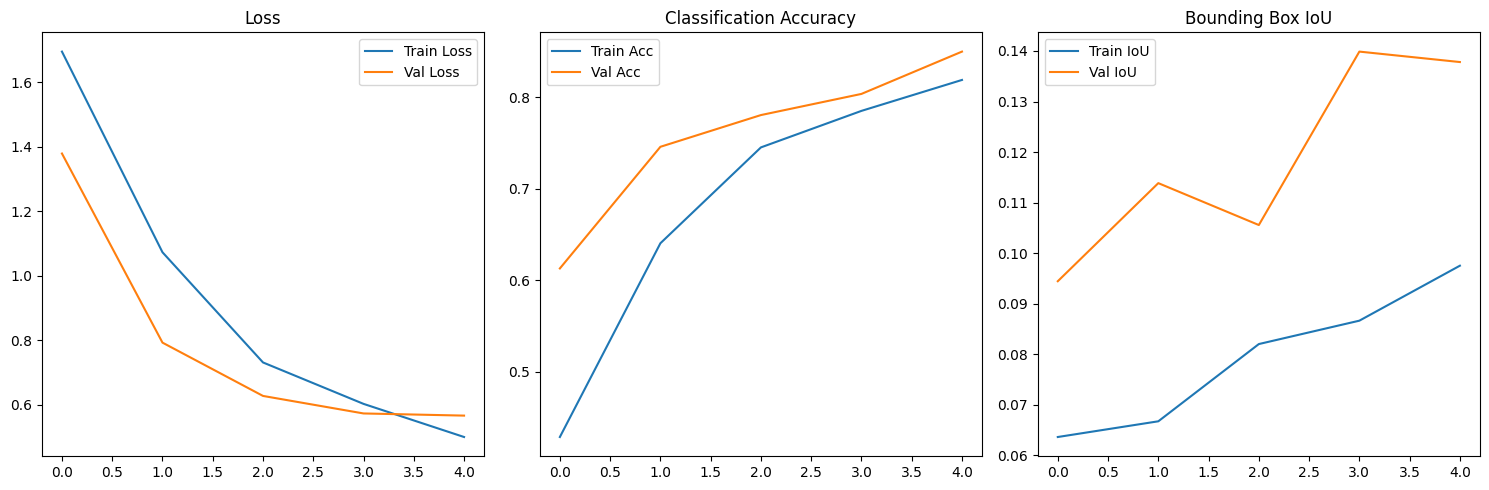

In [12]:
# Main execution
if __name__ == "__main__":
    # Load annotations
    train_ann = load_annotations("BoneFractureYolo8/train_annotations.coco.json")
    valid_ann = load_annotations("BoneFractureYolo8/valid_annotations.coco.json")
    
    # train_data = [ann for ann in train_ann if len(ann['annotations']) > 0]
    # valid_data = [ann for ann in valid_ann if len(ann['annotations']) > 0]
    # Create datasets
    train_ds = BoneFractureDataset(train_ann, "BoneFractureYolo8/train/images", get_transforms(train=True))
    valid_ds = BoneFractureDataset(valid_ann, "BoneFractureYolo8/valid/images", get_transforms(train=False))
    
    # Handle class imbalance
    # class_counts = [train_ds.class_distribution[0], train_ds.class_distribution[1]]
    class_counts = [train_ds.class_distribution[i] for i in range(NUM_CLASSES)]
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights.to(DEVICE)
    
    # Create data loaders
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True
    )
    valid_loader = DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False
    )
    
    # Initialize model
    model = FractureDetectionModel()
    
    # Train the model
    history, complete_model = train_model(model, train_loader, valid_loader, class_weights)
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Classification Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('Bounding Box IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

CNN Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.75      0.81        28
     Class 1       0.94      0.80      0.87        41
     Class 2       0.85      0.89      0.87        37
     Class 3       0.90      0.84      0.87        31
     Class 4       0.79      1.00      0.88        19
     Class 5       0.68      0.88      0.77        17

    accuracy                           0.85       173
   macro avg       0.84      0.86      0.84       173
weighted avg       0.86      0.85      0.85       173



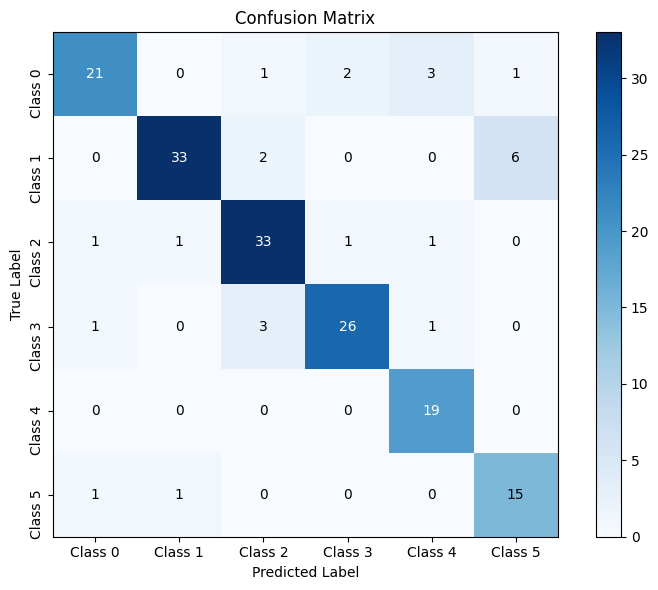

In [16]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Make sure your model is in eval mode
complete_model.eval()

# Collect all true labels and predictions
y_true = []
y_pred = []

with torch.no_grad():
    for batch in valid_loader:
        images = batch['image'].to(DEVICE)
        labels = batch['classification'].to(DEVICE)
        
        outputs = complete_model(images)['classification']      # [B, 7]
        preds   = outputs.argmax(dim=1)                         # [B]
        
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

# Define your 7 class names (adjust to your actual category names)
class_names = [
    "Class 0", "Class 1", "Class 2",
    "Class 3", "Class 4", "Class 5"
]

# 1) Classification Report
print("CNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 2) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names, rotation=90)

# Annotate each cell with its count
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], "d"),
             ha="center",
             va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


Validation MSE: 0.0150
Mean IoU: 0.0859


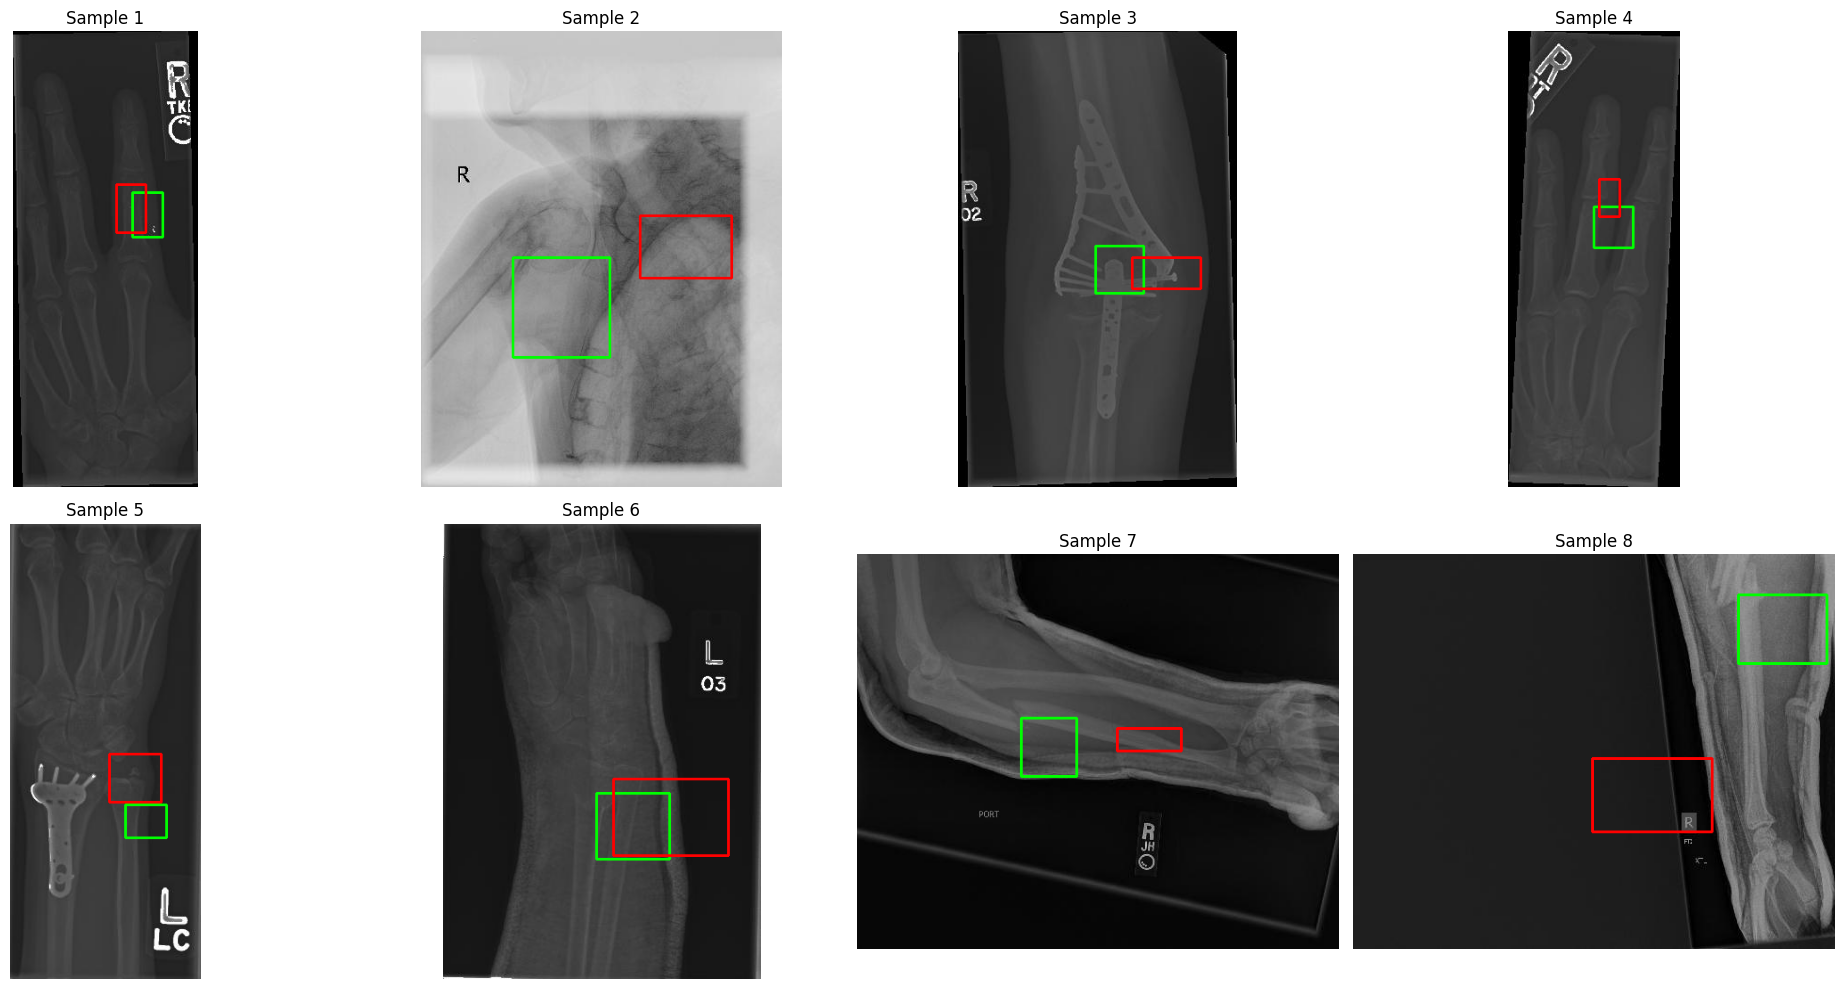

In [17]:
from sklearn.metrics import mean_squared_error
def evaluate_model(model, dataloader, dataset, device, num_samples=8):
    model.eval()
    all_bbox_preds = []
    all_bbox_true = []
    all_images = []
    orig_sizes = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            bbox_true = batch['bbox'].cpu().numpy()
            
            # Get predictions
            outputs = model(images)
            bbox_pred = outputs['bbox'].cpu().numpy()
            
            all_bbox_preds.extend(bbox_pred)
            all_bbox_true.extend(bbox_true)
            
            # Store original image sizes and images for visualization
            for i in range(images.size(0)):
                img_path = dataset.processed_data[i]['img_path']
                orig_h, orig_w = cv2.imread(img_path).shape[:2]
                orig_sizes.append((orig_w, orig_h))
                all_images.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

    # Convert to numpy arrays
    bbox_pred = np.array(all_bbox_preds)
    bbox_true = np.array(all_bbox_true)

    # Calculate MSE
    mse = mean_squared_error(bbox_true, bbox_pred)
    print(f"Validation MSE: {mse:.4f}")

    # Calculate IoU
    ious = []
    for pred, true, (orig_w, orig_h) in zip(bbox_pred, bbox_true, orig_sizes):
        # Denormalize coordinates
        pred_denorm = [
            pred[0] * orig_w,
            pred[1] * orig_h,
            pred[2] * orig_w,
            pred[3] * orig_h
        ]
        true_denorm = [
            true[0] * orig_w,
            true[1] * orig_h,
            true[2] * orig_w,
            true[3] * orig_h
        ]
        ious.append(calculate_iou(pred_denorm, true_denorm))
    
    mean_iou = np.mean(ious)
    print(f"Mean IoU: {mean_iou:.4f}")

    # Plot sample predictions
    plot_predictions(all_images[:num_samples], 
                    bbox_true[:num_samples], 
                    bbox_pred[:num_samples], 
                    orig_sizes[:num_samples])

def calculate_iou(box1, box2):
    """Calculate Intersection over Union for denormalized boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0

def plot_predictions(images, true_boxes, pred_boxes, orig_sizes):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        image = images[i]
        true_box = true_boxes[i]
        pred_box = pred_boxes[i]
        orig_w, orig_h = orig_sizes[i]

        # Denormalize boxes
        true_box = [
            true_box[0] * orig_w,
            true_box[1] * orig_h,
            true_box[2] * orig_w,
            true_box[3] * orig_h
        ]
        pred_box = [
            pred_box[0] * orig_w,
            pred_box[1] * orig_h,
            pred_box[2] * orig_w,
            pred_box[3] * orig_h
        ]

        # Draw boxes
        image = cv2.rectangle(image.copy(),
                            (int(true_box[0]), int(true_box[1])),
                            (int(true_box[0] + true_box[2]), int(true_box[1] + true_box[3])),
                            (0, 255, 0), 2)
        image = cv2.rectangle(image.copy(),
                            (int(pred_box[0]), int(pred_box[1])),
                            (int(pred_box[0] + pred_box[2]), int(pred_box[1] + pred_box[3])),
                            (255, 0, 0), 2)

        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage after training
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, valid_loader, valid_ds, DEVICE)